In [46]:
#@title Импорт библиотек
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from abc import abstractmethod
from scipy.spatial.distance import cityblock
from scipy.special import softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import AdamW
from IPython.display import Image, display, clear_output
import imageio.v2 as imageio
from functools import lru_cache
import gc
import tempfile
from tqdm import tqdm
from typing import NamedTuple, Callable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import deque
PATH = 'data'
tag = 'q_'
os.makedirs(f'{PATH}/{tag}images', exist_ok=True)
os.makedirs(f'{PATH}/{tag}fit', exist_ok=True)
os.makedirs(f'{PATH}/{tag}weights', exist_ok=True)

In [47]:
#@title Среда
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Проверка доступных GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Найдено GPU: {len(gpus)}")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("GPU не обнаружены")

# Проверка, используется ли GPU по умолчанию
print("Используется ли GPU по умолчанию:", tf.test.is_gpu_available())

# Альтернативный способ проверки (для новых версий TensorFlow)
print("GPU доступен:", tf.test.is_gpu_available(cuda_only=True))

TensorFlow version: 2.19.0
Найдено GPU: 1
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Используется ли GPU по умолчанию: True
GPU доступен: True


I0000 00:00:1750067855.877062   20876 gpu_device.cc:2019] Created device /device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1750067855.882342   20876 gpu_device.cc:2019] Created device /device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [48]:
#@title Насьройка логирования
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(f'{PATH}/{tag}training.log', encoding='utf-8')
    ]
)
logger = logging.getLogger(__name__)

In [49]:
#@title Параметры карты
class Colors:
    wall  = -1
    empty = 0
    sheep = 1
    sheep_smell = 2
    weed  = 3
    wolf  = 4
    wolf_smell = 5
    
def scaler_areas(areas: np.array) -> np.array:
    colors_dict = {k: v for k, v in vars(Colors).items() if not k.startswith('__')}
    max_val = max(colors_dict.values())
    min_val = min(colors_dict.values())

    return (areas - min_val) / (max_val - min_val)

In [50]:
#@title Трава
class Weed:
    color = Colors.weed
    def __init__(self, name: str, color:int=None):
      self.name = name
      self.color = Colors.weed if color is None else color

In [51]:
#@title Животные
class Animal:
    speed: int = 1
    vision: int # Дальновидность
    color = None
    smell = None
    len_smell = None
    
    def __init__(self, name: str=''):
      self.name = name
      self.areas: list[np.array] = []
      self.moves: list[int] = []
      self.rewards: list[int] = []
      self.visited: deque[tuple[int,int]] = deque(maxlen=self.len_smell) # память где посещяли
    
    @abstractmethod
    def step(self, area: np.array) -> int:
        '''
        0 - LEFT
        1 - UP
        2 - RIGTH
        3 - DOWN
        '''
        pass

    @classmethod
    def target(cls, area: np.array, color: int) -> tuple:
        # Находим координаты всей интересующих объектов
        target_pos = np.argwhere(area == color)

        if target_pos.size == 0:
            return None, None

        # Вычисляем Манхэттенское расстояние до каждого объекта
        subject = np.array((cls.vision, cls.vision))
        distances = np.array([cityblock(subject, pos, [cls.speed, cls.speed])
                              for pos in target_pos])
        best = np.argmin(distances)
        return target_pos[best], distances[best]

    @classmethod
    def cost(cls, area: np.array, color: int) -> int:
      target, dist = cls.target(area, color)
      if target is None:
        return 0
      return cls.vision - dist

In [52]:
#@title Травоядные
class Sheep(Animal):   # овечка
    vision: int = 4
    brain: Sequential = None
    color = Colors.sheep
    smell = Colors.sheep_smell
    len_smell = 15
    enemy_smell = Colors.wolf
    
    def state(self, serials: int = 1, step: int = None) -> np.array:
      if not len(self.areas):
          raise RuntimeError("У агента нет состояний")
          
      if not step or step < 0: 
          step = len(self.areas)
      a = step - serials
      areas = np.array(self.areas[a:step]) if a >=0 else np.array(self.areas[:step])  
      if a < 0:
        padded = np.repeat(areas[:1,:,:], -a, axis=0)
        areas = np.concatenate((padded, areas), axis=0)
      areas = np.expand_dims(areas, axis=-1)
      return scaler_areas(areas)
           
    def step(self, state: np.array, verbose=0) -> int:
        state = np.expand_dims(state, axis=0)
        pred = self.brain.predict(state, verbose=verbose)
        action = int(np.argmax(pred[0], axis=1)[0])
        return action

    @classmethod
    def steps(cls, states: np.array, verbose=0, epsilon=0.1, actions=4) -> list[int]:
        if np.random.uniform() < epsilon:
            return [int(a) for a in np.random.randint(actions, size=len(states))]
        q_values = cls.brain.predict(states, verbose=verbose)
        if epsilon >= 0:
            return [int(a) for a in np.argmax(q_values, axis=1)]
        return [int(np.random.choice(actions, p=softmax(q))) for q in q_values] # вариан из CE
        

In [53]:
#@title Плодоядные
class Wolf(Animal): # волки
    vision: int = 12
    speed:  int = 1
    color = Colors.wolf
    smell = Colors.wolf_smell
    len_smell = 10
    enemy_smell = Colors.sheep
    
    def step(self, area: np.array, random_move:float=1) -> int:
      if random_move > np.random.uniform():
          return int(np.random.choice([0, 1, 2, 3, 4])) 
           
      target, dist = self.target(area, Sheep.color)
      if target is None:
        return int(np.random.choice([0, 1, 2, 3])) 

      dy = target[0] - self.vision
      dx = target[1] - self.vision
      if abs(dy) > abs(dx):
        return 1 if dy < 0 else 3
      else:
        return 0 if dx < 0 else 2

In [54]:
class Rewards:
    class Sheep:
        sheep_eat_weed = 10
        wolf_eat_sheep = -100
        exploration_area = 1
        previously_visited = 0
        touched_wall = 0
        touched_sheep = 0
        wolf_detected = -50
        wolf_small_detected = -10
        
    @staticmethod
    def get_scaler(gamma: float, depth: int, how = None) -> MinMaxScaler:
        if how is None:
            how = Rewards.Sheep
        rewards_dict = {k: v for k, v in vars(how).items() if not k.startswith('__')}
        max_reward = max(rewards_dict.values())
        min_reward = min(rewards_dict.values())
        # Вычисляем сумму геометрической прогрессии для max Q
        max_q = max_reward * (1 - gamma**depth) / (1 - gamma)
        # Аналогично для min Q
        min_q = min_reward * (1 - gamma**depth) / (1 - gamma)
        
        # Создаем массив из min и max Q для обучения скейлера
        q_values = np.array([[min_q], [max_q]])
        
        # Инициализируем и обучаем MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(q_values)
        
        return scaler

In [55]:
class GameOmniHunters:    
    def __init__(self, shape:tuple[int, int]):
        self.state = np.empty(shape, dtype=object)
        self.images = []

    def view(self) -> np.array:
      view = np.vectorize(lambda obj: Colors.empty if obj is None else obj.color)
      return view(self.state)

    def start(self, model, sheeps: int, wolves: int, e: int = 0):
      Sheep.brain = model
      self.sheeps = []
      self.wolfs = []
      height, width = self.state.shape
      assert sheeps <= height
      assert wolves <= height
      self.state[:] = None

      # Размещение овечек у левой границы (столбец 0)
      for i in np.random.choice(height, size=sheeps, replace=False):
          sheep = Sheep(name=f"Sheep_{e}_{i}")
          self.sheeps.append(sheep)
          self.state[i, np.random.randint(Sheep.vision*2)] = sheep

      # Размещение волков у правой границы (последний столбец)
      for i in np.random.choice(height, size=wolves, replace=False):
          wolf = Wolf(name=f"Wolf_{i}")
          self.wolfs.append(wolf)
          self.state[i, width - 1] = wolf
          
        
    def area(self, animal:Animal, x:int, y:int) -> np.array:  
        view = self.view()
        
        # Заполняем посещеные клетки
        for x_visited, y_visited in animal.visited:
           if view[y_visited, x_visited] == Colors.empty:
               view[y_visited, x_visited] = animal.smell

        # Заполняем клетки с запахом противника
        for enemy in self.get_enemis(animal):
            for x_visited, y_visited in enemy.visited:
               if view[y_visited, x_visited] == Colors.empty: 
                   view[y_visited, x_visited] = enemy.smell
        
        # Добавляем паддинг вокруг view    
        padded_view = np.pad(view, pad_width=animal.vision,
                          mode='constant', constant_values=Colors.wall)
  
        # Вырезаем область вокруг животного, сдвигая координаты внутри среза
        area = padded_view[
          (y):(y + 2 *animal.vision),
          (x):(x + 2 *animal.vision)
        ]

        return area

    def get_enemis(self, animal: Animal) -> list[Animal]:
        if type(animal) == Wolf:
            return self.sheeps
        if type(animal) == Sheep:
            return self.wolfs
        
    def add(self, weeds: int, poison:float=0):
      # Размещение травы в свободных местах
      free_pos = np.argwhere(self.state == None)
      mask = (
          (free_pos[:, 1] != 0) &
          (free_pos[:, 1] != self.state.shape[1] - 1)
      )
      free_pos = free_pos[mask]
      assert len(free_pos) > weeds
      chosen_indices = np.random.choice(len(free_pos), size=weeds, replace=False)
      for y, x in free_pos[chosen_indices]:
        self.state[y, x] = Weed(name=f"Weed_{y}_{x}", color=Weed.color if poison<np.random.uniform() else Wolf.color )

    def count(self, animal: Animal) -> int:
        is_animal = np.array([isinstance(obj, animal) for obj in self.state.flatten()]).reshape(self.state.shape)
        return np.sum(is_animal)
        
    def step(self, serials_sheep_cv:int = 1, 
             random_move_sheep:float=0, 
             random_move_wolf:float=0,
             kill_sheep:bool=True) -> int: # Сколько уничтожили травы
      weeds = {"sheeps": 0, "wolfs": 0}

      # Коллективный ход овечек
      mask = np.vectorize(lambda obj: isinstance(obj, Sheep))(self.state)
      coords = np.where(mask)
      states = []
      for y, x in zip(coords[0], coords[1]):
        sheep = self.state[y, x]
        area = self.area(sheep, x, y)
        sheep.areas.append(area)
        state = sheep.state(serials_sheep_cv, len(sheep.areas) - serials_sheep_cv)
        state = np.concatenate(state[:serials_sheep_cv], axis=2)
        states.append(state)
      if not len(states):
          raise RuntimeError("Aгентов не обнаружено")    
      moves = Sheep.steps(np.array(states), epsilon=random_move_sheep)
          
      # Расчет колизий и rewards
      for (y, x), move in zip(zip(coords[0], coords[1]), moves):
        sheep = self.state[y, x]
        sheep.moves.append(move)
        weed, reward = self.conflict(sheep, [x, y], move, kill_sheep)
        weeds['sheeps'] += weed
        sheep.rewards.append(reward)

      # Ход волков
      mask = np.vectorize(lambda obj: isinstance(obj, Wolf))(self.state)
      coords = np.where(mask)
      for y, x in zip(coords[0], coords[1]):
        wolf = self.state[y, x]
        move = wolf.step(self.area(wolf, x, y),random_move=random_move_wolf)
        if 4 == move: continue # пропуск хода
        weed, _ = self.conflict(wolf, (x, y), move, kill_sheep)
        weeds['wolfs'] += weed
      
      self.images.append(self.view())
      return weeds

    def conflict(self, how: Animal, fm: tuple[int, int], mv: int, kill_sheep:bool) -> tuple[int, int]: # weeds killed, rewards
      x, y = fm
      fm = (int(x), int(y))
      x, y = fm 
      if 0 == mv: x = int(max(x - how.speed, 0))    # ⬅️
      if 1 == mv: y = int(max(y - how.speed, 0))    # ⬆️
      if 2 == mv: x = int(min(x + how.speed, self.state.shape[1] - how.speed)) # ➡️
      if 3 == mv: y = int(min(y + how.speed, self.state.shape[0] - how.speed)) # ⬇️
  
      if (x, y) != fm: # тут точно передвинемся
        self.state[fm[1], fm[0]] = None
        how.visited.append((fm[0], fm[1])) # сохраняем точку откуда ушли
        
      target = self.state[y, x]
      self.state[y, x] = how                
      
      if type(how) == Sheep:

        if target is None: # Пустая клетка
            if (x, y) in list(how.visited): # уже посещали ячейку
                return 0, Rewards.Sheep.previously_visited
            if Wolf.color in how.areas[-1]:
                return 0, Rewards.Sheep.wolf_detected
            if (x, y) in sum([list(wolf.visited) for wolf in self.wolfs], []):
                return 0, Rewards.Sheep.wolf_small_detected
            return 0, Rewards.Sheep.exploration_area # бонус за исследование
            
        if type(target) == Weed:
            #  Трава или яд
            return 1, Rewards.Sheep.sheep_eat_weed if target.color == Weed.color else Rewards.Sheep.wolf_eat_sheep
            
        if type(target) == Sheep: 
            if target == how: # выход за карту
                return 0, Rewards.Sheep.touched_wall
            else: # обмен местами
                self.state[fm[1], fm[0]] = how
                self.state[y, x] = target
                return 0, Rewards.Sheep.touched_sheep
              
                
        if type(target) == Wolf: # овца наткнулась на волка или отравленную траву
            self.state[y, x] = target
            if not kill_sheep:
                self.state[fm[1], fm[0]] = how
            return 0, Rewards.Sheep.wolf_eat_sheep
            

      if type(how) == Wolf:
        if type(target) == Sheep: # волк съел овцу
          target.rewards[-1] = Rewards.Sheep.wolf_eat_sheep # у овцы награда за действие меняется
          if not kill_sheep:
              self.state[fm[1], fm[0]] = target
          return 0, 0
            
        if type(target) == Weed: # волк затоптал траву
            return 1, 0
            
        if type(target) == Wolf: # обмен позициями
            self.state[fm[1], fm[0]] = how
            self.state[y, x] = target
            
      return 0, 0


    def play(self, name, show=True):
      
      gifname = f'{PATH}/{tag}images/{name}.gif'
      images = []
  
      for i, view in enumerate(self.images):
          fig, ax = plt.subplots()
          ax.imshow(view)
          ax.set_title(f"Step {i + 1}")
          ax.axis('off')
  
          # Создаем временный файл с контекстным менеджером
          with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
              fig.savefig(tmpfile.name, bbox_inches='tight')
              plt.close(fig)
              images.append(imageio.imread(tmpfile.name))
          
          # Удаляем временный файл после чтения
          os.remove(tmpfile.name)
  
      if not images:
          logger.error("Ошибка: список изображений пуст, GIF не создан.")
          return
  
      imageio.mimsave(gifname, images)
  
      if show:
          with open(gifname, 'rb') as f:
              display(Image(f.read(), width=600))


Model: "SheepBrain"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,868 (1.01 MB)

 Trainable params: 264,868 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

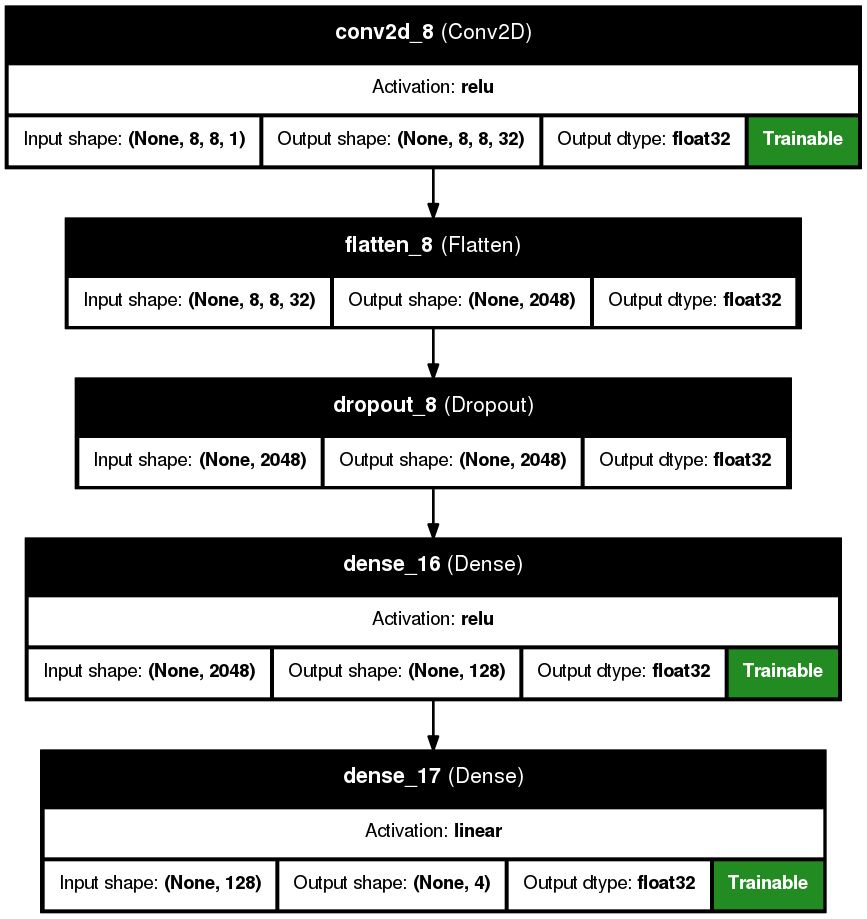

In [56]:
#@title Модель
def get_model():
    input_shape = (8, 8, 1) # текущий и предыдущий кадр
    return Sequential([
        Input(shape=(8, 8, 1) , name='input_layer'),
        Conv2D(32, 8, activation='relu', padding='same'),
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(4)
    ], name='SheepBrain')
    
model = get_model()
model.compile(optimizer=AdamW(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
model.summary()
utils.plot_model(model, dpi=96, to_file=f'docs/umls/{tag}model.png', show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)

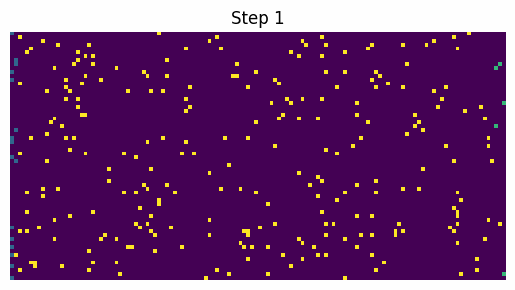

In [57]:
#@title Запуск игры
height, width = 64, 128
shape = (height, width)
gifname = 'docs/images/not_fit.gif'
if os.path.isfile(gifname):
    with open(gifname, 'rb') as f:
       display(Image(f.read(), width=600))
else:
    
    g = GameOmniHunter(shape)
    g.start(model, height//4, height//12)
    g.add(2*width)
    while True:
      try:
          g.add(g.step())
      except: 
          break
    g.play('not_fit')

In [58]:
class Gamma:
    def __init__(self, base: float, level: int):
        assert 0 <= base <= 1, (
            "Коэффициент дисконтирования должен быть между 0 и 1."
        )
        self.base = base
        self.level = level
        self.gamma = [base ** power for power in range(level)]
        
    @lru_cache(maxsize=1024)
    def __call__(self, power: int, value: float):
        #assert power >= 0, (
        #    "Степень должна быть неотрицательным целым числом."
        #)
        try:
            return value * self.gamma[power]
        except:
            print(f"{power=}")
            raise

In [59]:
#@title Получение батчей
def get_batch(g: GameOmniHunters, target_model, level: int , scaler: MinMaxScaler, gamma: Callable, random_move_sheep: float = 0.1, alpha=0.1) -> tuple[list[np.array], list[np.array]]:
    level += 1 # + текущие состояние
    eat_weeds = 0
    for _ in range(level):
        weeds = g.step(random_move_sheep=epsilon)
        g.add(weeds['sheeps'] + weeds['wolfs'])
        eat_weeds += weeds['sheeps']

    x, y = [], []
    for sheep in g.sheeps:
        states = sheep.state(level)      # (level,8,8,1)
        current_state = states[0]        # (8,8,1)
        
        actions = sheep.moves[-level:] 
        action = actions[0] 
        rewards = sheep.rewards[-level:]         # награды за следующие (level-1) шагов
        rewards = scaler.transform(np.array(rewards).reshape(-1, 1)).flatten().tolist()
        
        q_values = target_model.predict(states, verbose=0)  # (level, 4)
        target_q = q_values[0].copy()                # Q для текущего состояния
        next_q = q_values[1:]                        # Q для последующих состояний


        # Вычисляем дисконтированную q_value шагов вперед
        discounted_q = 0
        for i, q in enumerate(next_q):
            discounted_q += gamma(i, q.max())

        # Формируем целевое значение Q по формуле Беллмана с учетом alpha
        target_value = rewards[0] + discounted_q 
        # Обновляем Q-значение для действия action с учётом скорости обучения alpha
        target_q[action] = target_q[action] + target_value

        x.append(current_state)
        y.append(target_q)

    return x, y, eat_weeds


In [60]:
def show_records(record_rewards, record_kills, record_death):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.title('Награды')
    plt.plot(record_rewards, label = "Награда за эпизод")                          
    plt.plot(np.convolve(record_rewards, np.ones(10), 'valid') / 10, label = "Скользящее среднее награды") 
    plt.xlabel("Итерация", fontsize = 16)                              
    plt.ylabel("Награда", fontsize = 16)
    plt.legend()   
    plt.subplot(122)
    plt.title('Статистики')
    plt.plot(record_kills, 'red', linestyle = '--', label = "Кол-во съединой травы врагов (сумма за 10 эпизодов)")              
    plt.plot(np.convolve(record_kills, np.ones(10), 'valid') / 10, 'black', label = "Кол-во съединой травы (скользящее среднее за 10 итераций)") 
    plt.xlabel("Итерация", fontsize = 16)                              
    plt.ylabel("Награда", fontsize = 16)
    plt.legend()  
    plt.show()

In [61]:
#@title Обучения
lvl_discont = 6                              # Глубина дисконитрования
g = 0.95                                     # Гамма  
gamma = Gamma(0.95, lvl_discont + 1)         # Буферизация дискотных вычислений
scaler = Rewards.get_scaler(g, lvl_discont)  # нормализатор наград
observation_steps = 1000                     # Количество шагов 
target_model_update_frequency = 200         # Частота обновления целевой  

initial_epsilon = 1             # Начальное значение эпсилона (вероятность принять рандомный шаг)    
epsilon = initial_epsilon       # Текущее значение эпсилона (инициализируется как стартовое значение)
final_epsilon = 0.01            # Минимальное значение эпсилона (должен быть выше 0)
epsilon_decay_steps = 1000       # Мы будем уменьшать значение эпсилона на протяжении 1000 шагов    
epsilon_decay_factor = (initial_epsilon - final_epsilon)/epsilon_decay_steps  # Задаем количество, на которое будем снижать эпсилон после каждого шага  
timesteps_per_train = 100       # Обучаем модель раз в 100 шагов
maximum_memory_length = 2000    # будет хранить не более 40 000 пар текущих и следующих состояний, действия и наград   
target_model = get_model()      # целевую сеть котороая не булет обучаться, толко обновляться 
target_model.set_weights(model.get_weights()) # синхронизация сети
frames_per_action = 4           #  брать стсояни через число дейсвий, уменьшая корреляцию данных

record_rewards = []          # награды за 10 эпизодов
record_kills = []            # количество съединой травы
record_death = []            # количество стычек с волками

episode_number = 1     # Инициализируем номер эпизода как 1
timestep = 0           # Инициализируем номер шага как 0

height, width = 32, 24
shape = height, width
game = GameOmniHunters(shape)
game.start(model, 32, 8)
game.add(10*width, poison=0.1)

# Инициализируем награды:

interval_reward = 0  # за интервал (10 эпизодов) как 0
interval_kills = 0   # за количество съединой травы (10 эпизодов) как 0
interval_death = 0   # за количество стычек с волками (10 эпизодов) как 0
states =  [] # statets
targets = [] # q_values
fits = 0
history = {'losses': [], 'accuracy': []}

In [ ]:
pbar = tqdm(range(1500))
    
for episode_number in pbar:
    clear_output(wait=True)
    game = GameOmniHunters(shape)
    game.start(model, 32, 8)
    game.add(int(np.random.uniform()*height*(width-5)), poison=np.random.uniform() * .5)
    step = 0
    
    while (sheeps_count := int(game.count(Sheep))) > 0 and observation_steps > step:
        try:
            x, y, eat_weeds = get_batch(game, target_model, lvl_discont, scaler, gamma, random_move_sheep=epsilon)
            states.extend(x)
            targets.extend(y)
            interval_kills += eat_weeds    
        except Exception as e:
            logging.info(f'{step} {e}')
        step += 1     
        timestep += 1
        pbar.set_description(f'{episode_number:04}.{step:02} {timestep=} {epsilon=:.4f} len={len(targets)} {interval_kills=} {sheeps_count=} {fits=}') 
        pbar.refresh()
        
    interval_death += 32 - sheeps_count
    interval_reward += sum([sum(s.rewards) for s in game.sheeps])  
    episode_number += 1   # Увеличиваем номер эпизода на 1:

    # Записываем результат раз в 10 эпизодов:
    if episode_number % 10 == 0 and episode_number > 0: 
      record_rewards.append(interval_reward)            
      record_kills.append(interval_kills)               
      record_death.append(interval_death)               
      
      interval_reward, interval_kills, interval_death = 0, 0, 0 
      show_records(record_rewards, record_kills, record_death)

    # Обучаем модель если достаточно данных в памяти
    if len(targets) >= maximum_memory_length: 
        x_data = np.array(states)
        y_data = np.array(targets)
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
        model.compile(optimizer=AdamW(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
        h = model.fit(
                x_train, y_train, epochs=256, validation_data=(x_test, y_test), verbose=1,
                callbacks=[
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
                    EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True, verbose=1)
                ]
            )
        val_acc = h.history.get('val_accuracy')[-1]
        val_loss = h.history.get('val_loss')[-1]
        history['losses'].append(val_loss)
        history['accuracy'].append(val_acc)
        
        states =  []
        targets = []
        fits += 1
        model.save(f'{PATH}/{tag}weights/Sheep_brain_{fits:02}.keras')
        
        game = GameOmniHunters(shape)
        game.start(model, 32, 8)
        game.add(10*width, poison=0.1)
        for i in range(100):
          try:
              weeds = game.step()
              game.add(weeds['sheeps'] + weeds['wolfs'])
          except: 
            pass
        game.play(f'{tag}Sheeps_fited_{fits:003}')
        
    # Обновляем целевую модель весами основной модели раз в заданное количество (5 000) шагов:
    if timestep % target_model_update_frequency == 0: 
        target_model.set_weights(model.get_weights())

    if epsilon > final_epsilon:                        
        epsilon -= epsilon_decay_factor

0198.04 timestep=3800 epsilon=0.8040 len=576 interval_kills=1809 sheeps_count=27 fits=49:  13%|▏| 198/1500 [2:38:34<15:0

In [ ]:
#@title График обучения
plt.figure(figsize=(12,7))
plt.title(f'Статистики обучения')
plt.plot(history['accuracy'], label='Точность обучения')
plt.plot(history['losses'], label='Ошибки обучения')
plt.xlabel('Эпоха')
plt.legend()
plt.show()

In [ ]:
#@title Результат
height, width = 64, 128
shape = (height, width)
game = GameOmniHunters(shape)
game.start(model, height//4, height//12)
game.add(2*width)
for i in range(1000):
  try:
      weeds = game.step()
      game.add(weeds['sheeps'] + weeds['wolfs'])
  except: 
    pass
game.play(f'{tag}Sheeps_fited_res2')